<a href="https://colab.research.google.com/github/jungmin0710/K-digital-PythonDeepLearning/blob/main/LSTM_Time_Series_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM - Time Serise Dataset
* 서울시 기후 데이터 : 2011년 01월 01일 ~ 2019년 12월 31일
* https://data.kma.go.kr/cmmn/main.do 기후통계분석 -> 
* 기온분석 -> 기간(20110101~20191231) -> 검색 -> CSV 다운로드 
* Seoul_Temp.csv

In [1]:
import warnings 

warnings.filterwarnings('ignore')

## 0.Import Packages 
* Packages

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential 
from keras.layers import Dense, LSTM

## 1. Colab File Upload 

### 1) 'Seoul_temp.csv' 파일을 Colab에 업로드 후 진행

In [3]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv' 
temp = pd.read_csv(url)

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3287 non-null   object 
 1   avg     3287 non-null   float64
 2   min     3287 non-null   float64
 3   max     3287 non-null   float64
dtypes: float64(3), object(1)
memory usage: 102.8+ KB


In [4]:
temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


## 2.Data Preprocessing

### 1) 일일 평균온도('avg') 변화 시각화
* 일일 평균온도 변화에 일정한 패턴 확인

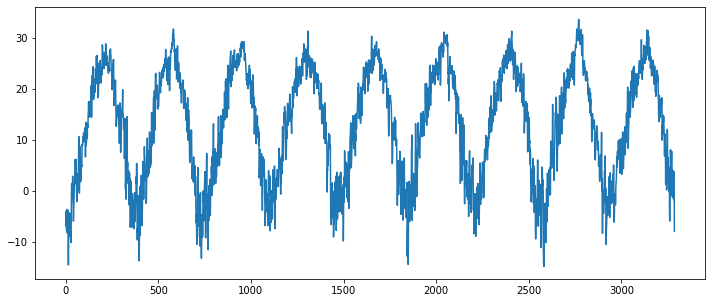

In [5]:
temp_data = temp[['avg']] 

plt.figure(figsize = (12, 5)) 
plt.plot(temp_data) 
plt.show()

### 2) Normalization
* tanh Activation 적용을 위해 -1 ~ 1 범위로 정규화

In [6]:
scaler = MinMaxScaler(feature_range = (-1, 1))

temp_data = scaler.fit_transform(temp_data)

### 3) Train vs. Test Split

* Train_Dataset : 2011년 01월 01일 ~ 2017년 12월 31일
* Test_Dataset : 2018년 01월 01일 ~ 2019년 12월 31일

In [7]:
train = temp_data[0:2557] 
test = temp_data[2557:]

## 3. 시계열 데이터 처리 함수

### 1) 시계열 학습용 데이터 생성 함수 정의
* X : 학습 평균온도 데이터 
* y : 정답 평균온도 데이터 
* 일정 기간의 X로 y를 예측하도록 학습

In [8]:
def create_dataset(time_data, look_back = 1): 
  data_X, data_y = [], []
  
  for i in range(len(time_data) - look_back): 
    data_X.append(time_data[i:(i + look_back), 0]) 
    data_y.append(time_data[i + look_back, 0])

  return np.array(data_X), np.array(data_y)

### 2) loop_back 기간 설정 후 학습데이터 생성
* 180일 기간 평균온도로 다음날 평균온도 예측 데이터 생성

In [9]:
look_back = 180

train_X, train_y = create_dataset(train, look_back) 
test_X, test_y = create_dataset(test, look_back)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180), (2377,), (550, 180), (550,))

### 3) Tensor Reshape

In [10]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1)) 
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180, 1), (2377,), (550, 180, 1), (550,))

## 4.LSTM Modeling

### 1) Model Define

In [11]:
model = Sequential() 
model.add(LSTM(64,
               input_shape = (None, 1)))
model.add(Dense(1, activation = 'tanh'))

* Model Summary

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


### 2) Model Compile

In [13]:
model.compile(loss = 'mean_squared_error', 
              optimizer = 'adam')

### 3) Model Fit

In [14]:
%%time

hist = model.fit(train_X, train_y, 
                 epochs = 200, 
                 batch_size = 16,
                 validation_data = (test_X, test_y))

Epoch 1/200
149/149 [==============================] - 12s 68ms/step - loss: 0.0522 - val_loss: 0.0164
Epoch 2/200
149/149 [==============================] - 9s 63ms/step - loss: 0.0167 - val_loss: 0.0148
Epoch 3/200
149/149 [==============================] - 9s 63ms/step - loss: 0.0157 - val_loss: 0.0121
Epoch 4/200
149/149 [==============================] - 9s 63ms/step - loss: 0.0132 - val_loss: 0.0144
Epoch 5/200
149/149 [==============================] - 9s 63ms/step - loss: 0.0128 - val_loss: 0.0105
Epoch 6/200
149/149 [==============================] - 10s 64ms/step - loss: 0.0110 - val_loss: 0.0096
Epoch 7/200
149/149 [==============================] - 9s 63ms/step - loss: 0.0108 - val_loss: 0.0084
Epoch 8/200
149/149 [==============================] - 9s 63ms/step - loss: 0.0093 - val_loss: 0.0081
Epoch 9/200
149/149 [==============================] - 9s 63ms/step - loss: 0.0085 - val_loss: 0.0093
Epoch 10/200
149/149 [==============================] - 9s 63ms/step - loss: 0.0

### 4) 학습결과 시각화

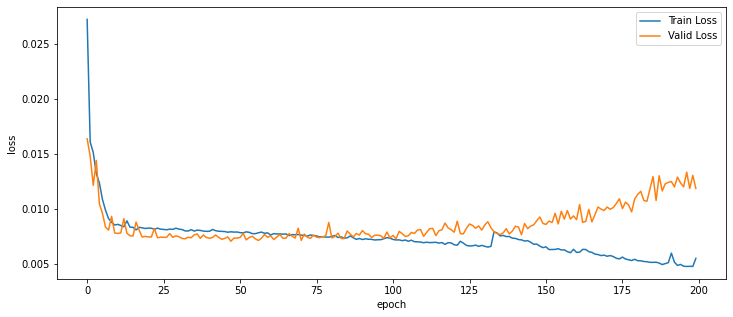

In [15]:
plt.figure(figsize = (12, 5)) 
plt.plot(hist.history['loss']) 
plt.plot(hist.history['val_loss'])

plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right') 
plt.show()

### 5) Model Evaluate

In [16]:
trainScore = model.evaluate(train_X, train_y, verbose = 0) 
print('Train Score: ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0) 
print('Test Score: ', testScore)

Train Score:  0.004991405177861452
Test Score:  0.011864205822348595


## 5.Model Predict

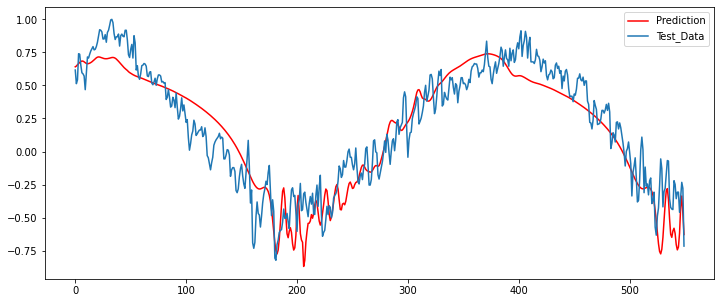

In [17]:
look_ahead = 550 

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1)) 
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size = 1) 
  predictions[i] = prediction 
  xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction') 
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data') 
plt.legend() 
plt.show()

본 내용은 2021/03/26(금)에 학습한 내용입니다.